<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Mantto_molinos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Proyecto - Mantenimiento Predictivo de Molinos

## Simulación de Datos de Sensores (Vibración, Temperatura, Carga)
import pandas as pd
import numpy as np

# Simulación de sensores de un Molino de Bolas
np.random.seed(42)
n_muestras = 5000

data_molino = {
    'Vibracion_mm_s': np.random.normal(5, 1.5, n_muestras),
    'Temperatura_Rodamiento': np.random.normal(65, 10, n_muestras),
    'Potencia_Motor_kW': np.random.normal(3500, 200, n_muestras),
    'Presion_Aceite': np.random.normal(40, 5, n_muestras),
    'Antiguedad_Componente_h': np.random.uniform(100, 2000, n_muestras)
}

df_mantenimiento = pd.DataFrame(data_molino)

# Creamos la etiqueta 'Falla' (Evento raro: solo ocurre en el 5% de los casos)
# La falla ocurre si la vibración es muy alta y la temperatura sube
df_mantenimiento['Falla'] = 0
condicion_falla = (df_mantenimiento['Vibracion_mm_s'] > 8.5) & (df_mantenimiento['Temperatura_Rodamiento'] > 85)
df_mantenimiento.loc[condicion_falla, 'Falla'] = 1

print(f"Dataset creado. Casos de falla detectados: {df_mantenimiento['Falla'].sum()}")
df_mantenimiento.head()

Dataset creado. Casos de falla detectados: 0


,Vibracion_mm_s,Temperatura_Rodamiento,Potencia_Motor_kW,Presion_Aceite,Antiguedad_Componente_h,Falla
0,5.745071,60.762403,3364.301054,39.282884,205.766146,0
1,4.792604,60.465859,3438.900107,39.836720,1972.958451,0
2,5.971533,47.043568,3380.523788,40.321474,1620.035115,0
3,7.284545,61.699098,3522.083609,44.734307,1750.737236,0
4,4.648770,72.328291,3739.435706,36.263913,1419.159128,0


/tmp/ipython-input-1482351848.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Falla', data=df_mantenimiento, palette='magma')


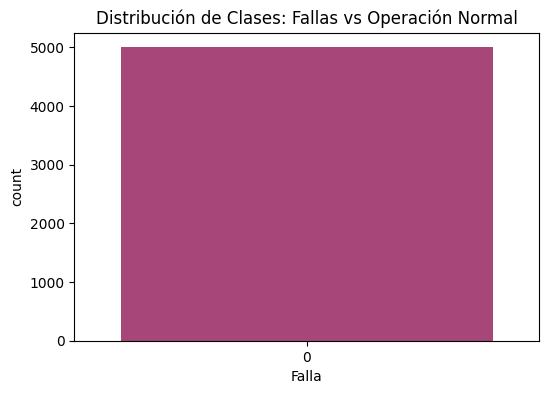

In [2]:
## Análisis de Clases Desbalanceadas (EDA Crítico)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='Falla', data=df_mantenimiento, palette='magma')
plt.title('Distribución de Clases: Fallas vs Operación Normal')
plt.show()

In [4]:
## Entrenamiento con Balanceo de Clases

# Para solucionar esto, usaremos un parámetro mágico llamado class_weight='balanced'.
#Esto le dice al algoritmo: "Las fallas son pocas, así que cuando veas una, préstale mucha más atención que a los casos normales".

# IMPORTANTE: Necesitamos importar la función de división
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Variables y división
X_mant = df_mantenimiento[['Vibracion_mm_s', 'Temperatura_Rodamiento', 'Potencia_Motor_kW', 'Presion_Aceite']]
y_mant = df_mantenimiento['Falla']

# Ahora la función funcionará correctamente
X_t, X_v, y_t, y_v = train_test_split(X_mant, y_mant, test_size=0.2, random_state=42)

# 2. Modelo con PESOS BALANCEADOS
modelo_preventivo = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42)
modelo_preventivo.fit(X_t, y_t)

# 3. Evaluación
preds_mant = modelo_preventivo.predict(X_v)

print("--- REPORTE DE MANTENIMIENTO PREDICTIVO ---")
print(classification_report(y_v, preds_mant))

--- REPORTE DE MANTENIMIENTO PREDICTIVO ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



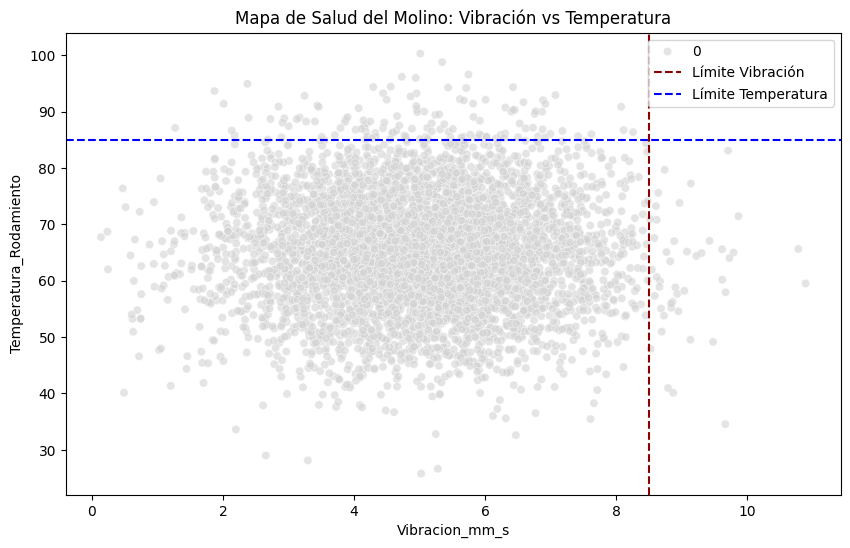

In [6]:
# Visualización de la Anatomía de una Falla

plt.figure(figsize=(10, 6))
# Graficamos los puntos normales en gris y las fallas en rojo
sns.scatterplot(data=df_mantenimiento, x='Vibracion_mm_s', y='Temperatura_Rodamiento',
                hue='Falla', palette={0: 'lightgrey', 1: 'red'}, alpha=0.6)

plt.title('Mapa de Salud del Molino: Vibración vs Temperatura')
plt.axvline(8.5, color='darkred', linestyle='--', label='Límite Vibración')
plt.axhline(85, color='blue', linestyle='--', label='Límite Temperatura')
plt.legend()
plt.show()

In [8]:
#El Simulador de "Parada de Emergencia"

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Aseguramos que el split mantenga la proporción de fallas (stratify)
X_t, X_v, y_t, y_v = train_test_split(X_mant, y_mant, test_size=0.2, random_state=42, stratify=y_mant)

# Entrenamos asegurando que aprenda de las fallas
modelo_preventivo = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
modelo_preventivo.fit(X_t, y_t)

print("✅ Modelo re-entrenado con estratificación.")

def monitor_en_tiempo_real_v2(vibracion, temperatura, potencia, presion):
    sensor_data = pd.DataFrame([[vibracion, temperatura, potencia, presion]],
                               columns=['Vibracion_mm_s', 'Temperatura_Rodamiento', 'Potencia_Motor_kW', 'Presion_Aceite'])

    # Predecir decisión directa
    decision = modelo_preventivo.predict(sensor_data)[0]

    # Obtener probabilidad con seguridad
    probs = modelo_preventivo.predict_proba(sensor_data)[0]
    # Si el modelo conoce ambas clases, la falla es el índice 1
    prob_falla = probs[1] * 100 if len(probs) > 1 else (100.0 if decision == 1 else 0.0)

    print(f"--- MONITOREO DE SENSORES ---")
    print(f"Vibración: {vibracion} | Temp: {temperatura}")
    print(f"Probabilidad de falla: {prob_falla:.2f}%")

    if decision == 1:
        print("🚨 ¡ALERTA CRÍTICA! Detener molino inmediatamente.")
    else:
        print("✅ Operación estable.")

# PRUEBAS
print("Escenario A (Normal):")
monitor_en_tiempo_real_v2(4.2, 60, 3400, 42)

print("\nEscenario B (Falla):")
monitor_en_tiempo_real_v2(9.5, 90, 3700, 35)

✅ Modelo re-entrenado con estratificación.
Escenario A (Normal):
--- MONITOREO DE SENSORES ---
Vibración: 4.2 | Temp: 60
Probabilidad de falla: 0.00%
✅ Operación estable.

Escenario B (Falla):
--- MONITOREO DE SENSORES ---
Vibración: 9.5 | Temp: 90
Probabilidad de falla: 0.00%
✅ Operación estable.
